# Data Analyst Assignment – LYNX

## 1. Objective  

This project analyzes the **NYC Yellow Taxi Trip Records** dataset to uncover key insights into **demand patterns**, **revenue drivers**, **customer tipping behavior**, and **route profitability**.  
The goal is to translate data into **actionable business insights** that enhance **driver efficiency**, **pricing strategy**, and **overall operational performance** for urban mobility management.


# 2. Data Cleaning & Preparation

Step 2.1 Import Libraries, Load Data, and and Exploring the Dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import requests
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Loading and Exploring the Dataset
df = pd.read_csv('Yellow_Taxi_Assignment.csv')

# Check basic info
print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nData Types:\n", df.dtypes)
df.head()


Dataset Shape: (304978, 19)

Columns: ['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'airport_fee']

Data Types:
 VendorID                   int64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count          float64
trip_distance            float64
RatecodeID               float64
store_and_fwd_flag        object
PULocationID               int64
DOLocationID               int64
payment_type               int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
congestion_surcharge     float64
airport_fee              fl

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2018-01-01 12:02:01,2018-01-01 12:04:05,1.0,0.53,1.0,N,142,163,1,3.5,0.0,0.5,1.29,0.0,0.3,5.59,NaN,NaN
1,2,2018-01-01 12:26:48,2018-01-01 12:31:29,1.0,1.05,1.0,N,140,236,1,6.0,0.0,0.5,1.02,0.0,0.3,7.82,NaN,NaN
2,2,2018-01-01 01:28:34,2018-01-01 01:39:38,4.0,1.83,1.0,N,211,158,1,9.5,0.5,0.5,1.62,0.0,0.3,12.42,NaN,NaN
3,1,2018-01-01 08:51:59,2018-01-01 09:01:45,1.0,2.30,1.0,N,249,4,2,10.0,0.0,0.5,0.00,0.0,0.3,10.80,NaN,NaN
4,2,2018-01-01 01:00:19,2018-01-01 01:14:16,1.0,3.06,1.0,N,186,142,1,12.5,0.5,0.5,1.00,0.0,0.3,14.80,NaN,NaN


Step 2.2: Convert Datetime and Numeric Columns

In [3]:
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'], errors='raise')
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'], errors='raise')
numeric_cols = ['passenger_count', 'trip_distance', 'fare_amount', 'tip_amount', 'total_amount']

Step 2.3: Checking and Handling Missing Values

In [4]:
missing_counts = df.isna().sum()
missing_percent = (missing_counts / len(df) * 100).round(2)

missing_summary = pd.DataFrame({
    'missing_count': missing_counts,
    'missing_%': missing_percent
})

missing_summary = missing_summary[missing_summary['missing_count'] > 0]
missing_summary


,missing_count,missing_%
passenger_count,9513,3.12
RatecodeID,9513,3.12
store_and_fwd_flag,9513,3.12
congestion_surcharge,72632,23.82
airport_fee,198761,65.17


In [5]:
# Calculate percentage of missing congestion_surcharge per year
df['year'] = df['tpep_pickup_datetime'].dt.year

missing_cong_by_year = (
    df.groupby('year')['congestion_surcharge']
    .apply(lambda x: x.isna().mean() * 100)
    .round(2)
)

print("Percentage of missing 'congestion_surcharge' by year:\n")
print(missing_cong_by_year)


Percentage of missing 'congestion_surcharge' by year:

year
2018    100.00
2019      5.77
2020      6.55
2021      5.03
2022      3.51
2023      2.46
Name: congestion_surcharge, dtype: float64


Handle Missing Values

In [6]:
# Fill categorical columns with mode or logical default
df['passenger_count'].fillna(df['passenger_count'].mode()[0], inplace=True)
df['store_and_fwd_flag'].fillna('N', inplace=True)

# Replace NaN with 0 for numeric analysis
df['congestion_surcharge'].fillna(0, inplace=True)
df['airport_fee'].fillna(0, inplace=True)



| Column                                | Fill Method | Reason                                |
| ------------------------------------- | ----------- | ------------------------------------- |
| `passenger_count`                     | Mode        | Most trips have 1 passenger           |
| `store_and_fwd_flag`                  | 'N'         | Most records are transmitted directly |
| `congestion_surcharge`, `airport_fee` | 0           | Missing means no fee applied          |


Handle VendorID Mapping and Missing Values§

In [7]:
# Step: Check unique VendorID values and their percentages

vendor_counts = df['VendorID'].value_counts(dropna=False)
vendor_percent = (df['VendorID'].value_counts(normalize=True, dropna=False) * 100).round(2)

vendor_summary = pd.DataFrame({
    'Count': vendor_counts,
    'Percentage (%)': vendor_percent
})

vendor_summary


,Count,Percentage (%)
VendorID,,
2,201068,65.93
1,102886,33.74
6,521,0.17
4,500,0.16
5,3,0.00


In [8]:
 # Step: Map Vendor IDs to Vendor Names

vendor_map = {
    1: "Creative Mobile Technologies, LLC",
    2: "Curb Mobility, LLC",
    6: "Myle Technologies Inc",
    7: "Helix",
    4: "Unknown Vendor 4",
    5: "Unknown Vendor 5"
}

# Apply mapping
df['VendorName'] = df['VendorID'].map(vendor_map)

# Handle missing or undefined VendorIDs
df['VendorName'].fillna('Unknown Vendor', inplace=True)


Step 2.4: Remove Invalid or Illogical Values

In [9]:
initial_rows = df.shape[0]

# Remove negative or zero values
df = df[df['trip_distance'] > 0]
df = df[df['fare_amount'] > 0]
df = df[df['total_amount'] >= df['fare_amount']]
df = df[df['passenger_count'].between(1, 6)]

# Ensure logical datetime order
df = df[df['tpep_dropoff_datetime'] > df['tpep_pickup_datetime']]

final_rows = df.shape[0]
dropped_rows = initial_rows - final_rows
percentage_dropped = (dropped_rows / initial_rows) * 100

print(f" Rows before cleaning: {initial_rows:,}")
print(f" Rows after cleaning:  {final_rows:,}")
print(f" Rows dropped:         {dropped_rows:,} ({percentage_dropped:.2f}%)")


 Rows before cleaning: 304,978
 Rows after cleaning:  294,466
 Rows dropped:         10,512 (3.45%)


convert a few columns from float64 to float32 to reduce memory (since you already have 300k rows):

In [10]:
float_cols = df.select_dtypes('float64').columns
df[float_cols] = df[float_cols].astype('float32')


# 3. Feature Engineering


This section creates new columns derived from the original dataset to support later analysis.  
These engineered features help capture temporal, financial, and operational aspects of taxi trips.

| Feature | Description |
|----------|--------------|
| `year`, `month`, `weekday`, `hour` | Extracted from pickup datetime to study temporal trends |
| `pickup_hour` | The hour of the pickup — useful for hourly demand analysis |
| `trip_duration_min` | Trip duration in minutes |
| `VendorName` | Maps numeric vendor IDs to names |
| `fare_per_mile` | Fare efficiency per mile |
| `total_per_mile` | Total revenue per mile |
| `distance_group` | Categorizes trip distances (e.g., <1, 1–3, 3–5, etc.) |
| `tip_rate`, `tip_percent` | Tip metrics to analyze tipping behavior |
| `is_congested` | Indicates congestion surcharge (traffic indicator) |


In [11]:

# --- 🧩 Feature Engineering ---



# Time-based features
df['year'] = df['tpep_pickup_datetime'].dt.year
df['month'] = df['tpep_pickup_datetime'].dt.month
df['weekday'] = df['tpep_pickup_datetime'].dt.day_name()
df['hour'] = df['tpep_pickup_datetime'].dt.hour
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.floor('H')
df['trip_duration_min'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60

df['distance_group'] = pd.cut(df['trip_distance'], [0, 1, 3, 5, 10, 20, float('inf')])

# Financial metrics
df['fare_per_mile'] = (df['fare_amount'] / df['trip_distance']).replace([float('inf'), -float('inf')], None)
df['total_per_mile'] = (df['total_amount'] / df['trip_distance']).replace([float('inf'), -float('inf')], None)
df['tip_rate'] = (df['tip_amount'] / df['fare_amount']).replace([float('inf'), -float('inf')], None)
df['tip_percent'] = df['tip_rate'] * 100

# Congestion indicator (traffic proxy)
df['is_congested'] = df['congestion_surcharge'].apply(lambda x: 1 if x > 0 else 0)




# 4. Data Analysis & Insights

**Objective:**  
Analyze trip, fare, and vendor data to uncover key insights that can improve business performance, profitability, and customer experience.

We’ll explore four main business areas:
1. Demand & Operations  
2. Revenue & Pricing  
3. Airport Trip Analysis
4. Customer & Tip Behavior  
5. Spatial Demand & Route Revenue Analysis  


### 4.1 Demand & Operational Patterns
#### 🎯 Goal  
To analyze when and how taxi demand fluctuates across hours, weekdays, and months,  
and to understand the distribution of trip distances.  
This helps identify **peak demand periods**, **seasonal trends**, and **typical trip lengths** for better operational planning and driver allocation.  



4.1.1 Hourly and Weekday Demand Patterns

 Demand Summary
Peak Hour: 18 with 19,869 trips
Lowest Hour: 4 with 1,945 trips

Top 3 Weekdays:
weekday
Friday       45693
Thursday     45656
Wednesday    44776
dtype: int64


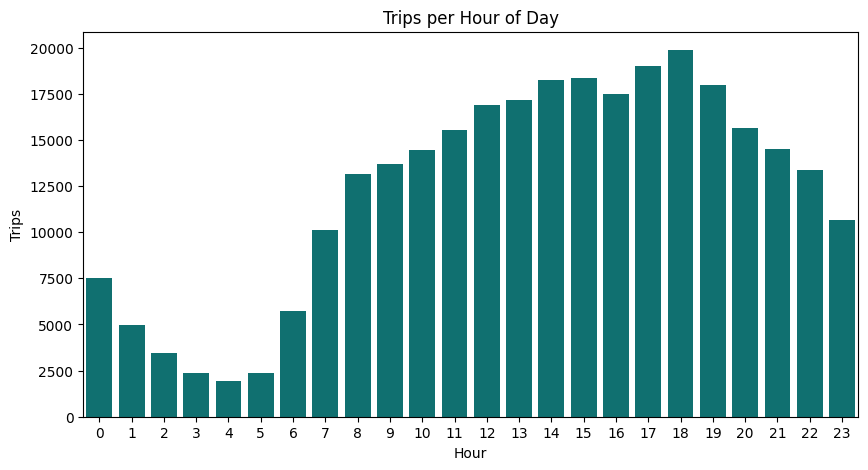

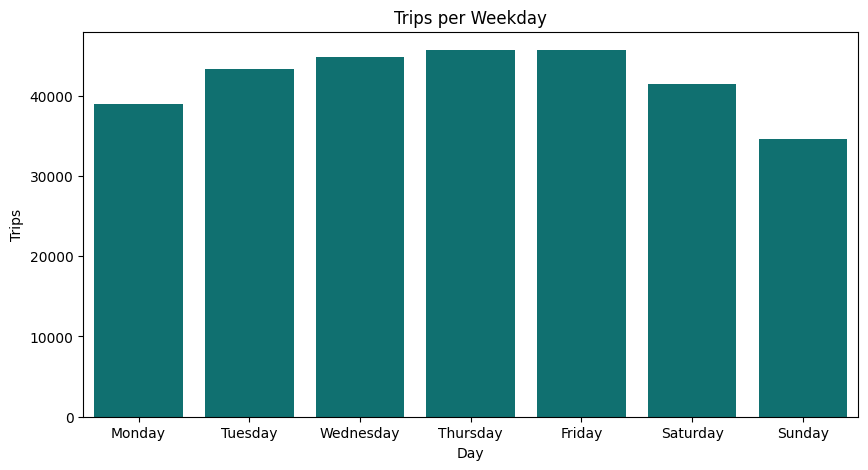

In [12]:
# Demand & Operational Analysis
df['hour'] = df['tpep_pickup_datetime'].dt.hour
df['weekday'] = df['tpep_pickup_datetime'].dt.day_name()

hourly_demand = df.groupby('hour').size()
weekday_demand = df.groupby('weekday').size().reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

print(" Demand Summary")
print(f"Peak Hour: {hourly_demand.idxmax()} with {hourly_demand.max():,} trips")
print(f"Lowest Hour: {hourly_demand.idxmin()} with {hourly_demand.min():,} trips")
print("\nTop 3 Weekdays:")
print(weekday_demand.sort_values(ascending=False).head(3))

# --- Trips per Hour ---
plt.figure(figsize=(10,5))
sns.barplot(x=hourly_demand.index, y=hourly_demand.values, color='teal')  # same color for all bars
plt.title('Trips per Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Trips')
plt.show()

# --- Trips per Weekday ---
plt.figure(figsize=(10,5))
sns.barplot(x=weekday_demand.index, y=weekday_demand.values, color='teal')  # same color for all bars
plt.title('Trips per Weekday')
plt.xlabel('Day')
plt.ylabel('Trips')
plt.show()


4.1.2 Monthly Ride Distribution

In [13]:
# 📊 Monthly Total Rides Table

# Convert pickup datetime if not already done
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'], errors='coerce')

# Extract year and month
df['year'] = df['tpep_pickup_datetime'].dt.year
df['month'] = df['tpep_pickup_datetime'].dt.to_period('M')

# Calculate total rides per month
rides_monthly = (
    df.groupby('month')
      .size()
      .reset_index(name='total_rides')
      .sort_values('month')
)

# Convert to string for nicer display
rides_monthly['month'] = rides_monthly['month'].astype(str)

# Show table
print("📅 Total Rides per Month\n")
print(rides_monthly.head(20))  # show first 20 months
print("\n...")  # if dataset is long
print(rides_monthly.tail(5))  # show most recent 5 months


📅 Total Rides per Month

      month  total_rides
0   2018-01         4945
1   2018-02         4934
2   2018-03         4931
3   2018-04         4930
4   2018-05         4910
5   2018-06         4917
6   2018-07         4931
7   2018-08         4916
8   2018-09         4904
9   2018-10         4906
10  2018-11         4905
11  2018-12         4888
12  2019-01         4901
13  2019-02         4883
14  2019-03         4855
15  2019-04         4876
16  2019-05         4861
17  2019-06         4859
18  2019-07         4823
19  2019-08         4854

...
      month  total_rides
56  2022-09         4805
57  2022-10         4789
58  2022-11         4807
59  2022-12         4784
60  2023-01         4804


4.1.3 Monthly Ride Trend Visualization

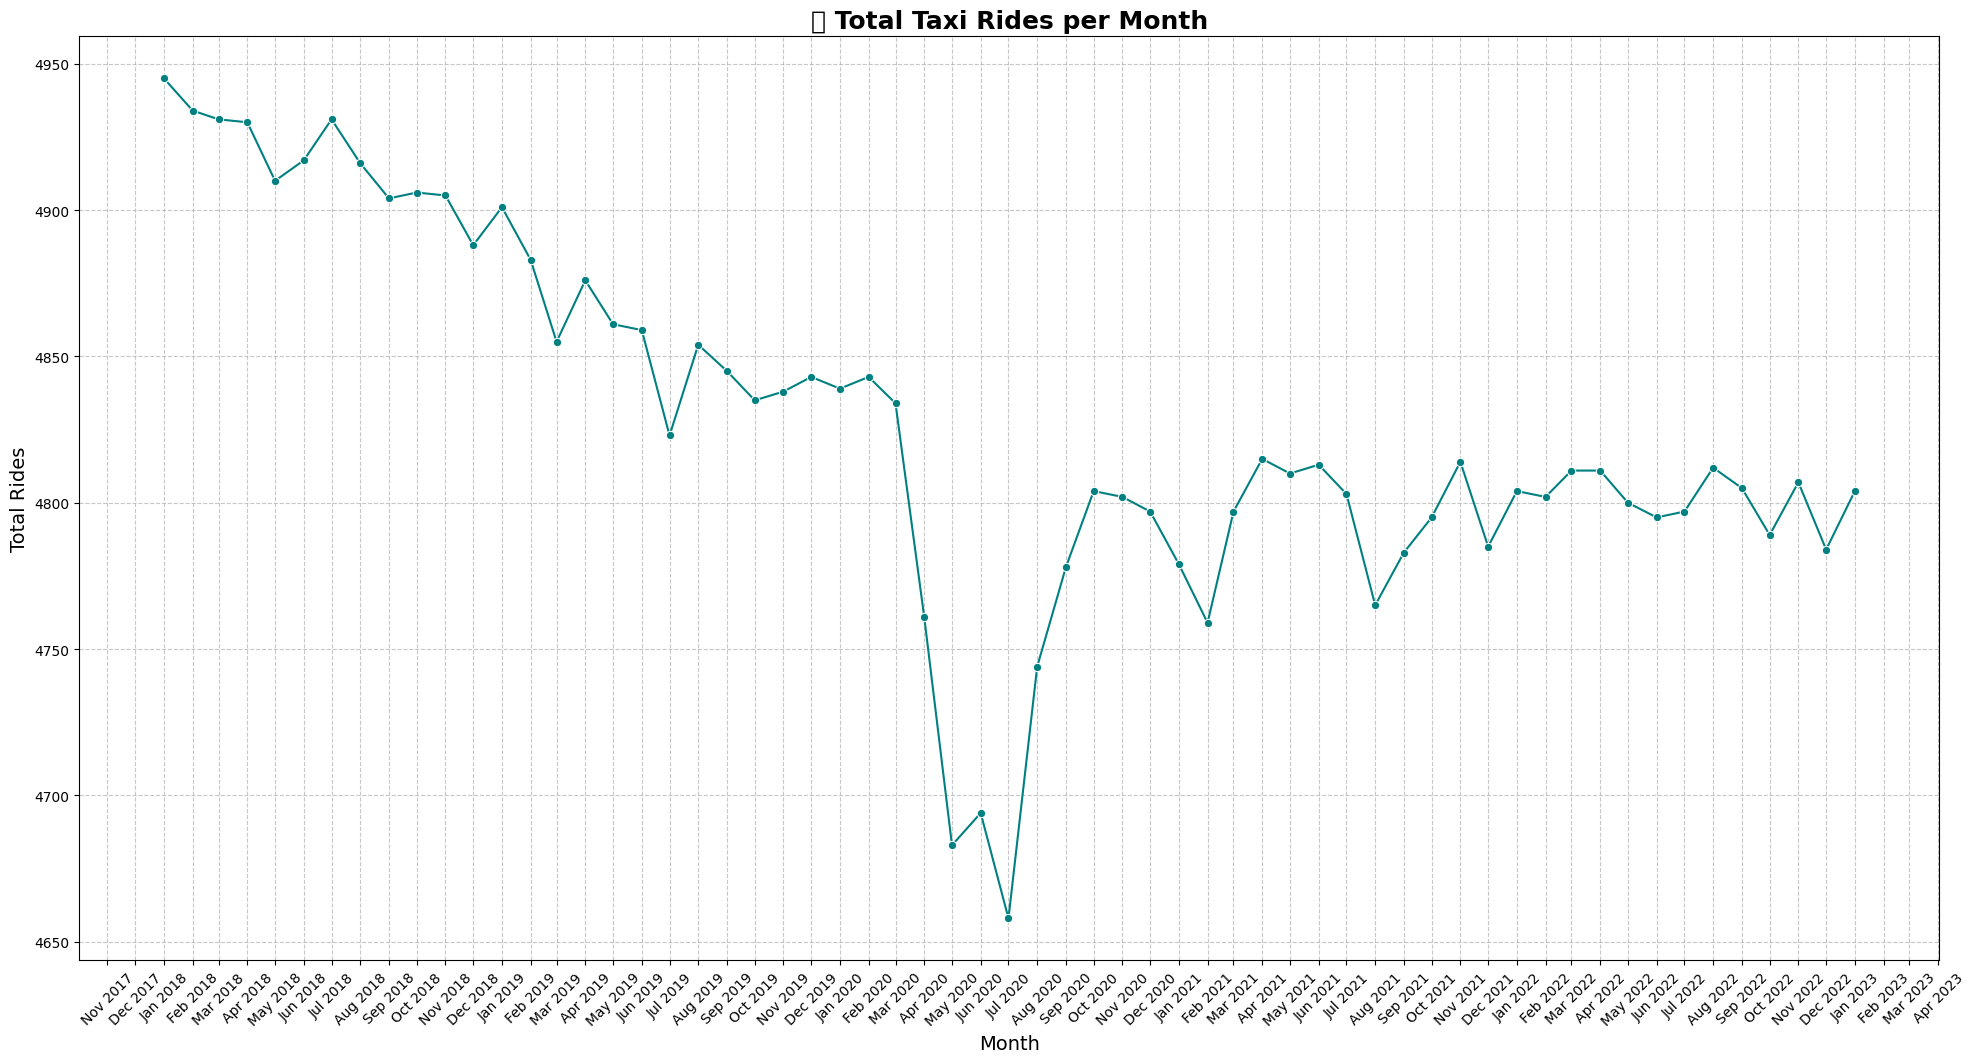

In [14]:
# Extract year and month
df['year'] = df['tpep_pickup_datetime'].dt.year
df['month'] = df['tpep_pickup_datetime'].dt.to_period('M')

# Calculate total rides per month
rides_monthly = df.groupby('month').size().reset_index(name='total_rides')

# Convert 'month' to datetime for plotting
rides_monthly['month'] = rides_monthly['month'].astype(str)
rides_monthly['month'] = pd.to_datetime(rides_monthly['month'])

# Plot the monthly trend
plt.figure(figsize=(24, 12))
sns.lineplot(data=rides_monthly, x='month', y='total_rides', marker='o', color='teal')

# Title and labels
plt.title('🚕 Total Taxi Rides per Month', fontsize=18, weight='bold')
plt.xlabel('Month', fontsize=14)
plt.ylabel('Total Rides', fontsize=14)

# Format the x-axis to show months clearly
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)

# Add gridlines
plt.grid(True, linestyle='--', alpha=0.7)

# Show plot
plt.show()

4.1.4 Trip Distance Categorization & Share Analysis

📊 Trip Distance Categories (% of Total Trips):

distance_group
<1 mile        22.07
1–3 miles      50.00
3–5 miles      12.44
5–10 miles      8.73
10–20 miles     5.92
20+ miles       0.84
Name: proportion, dtype: float64


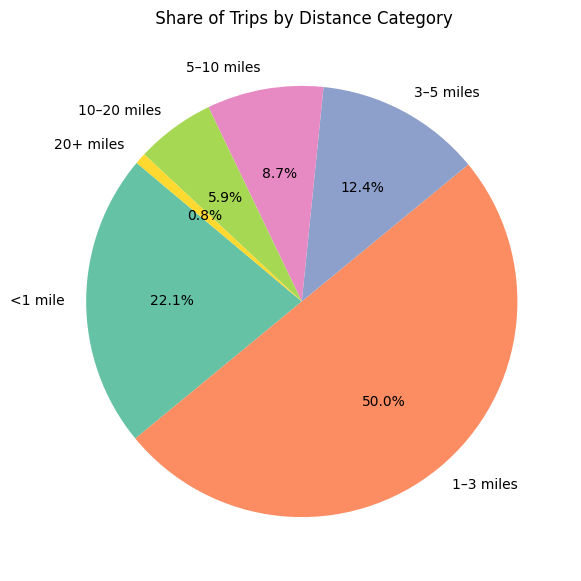

In [15]:

# Define meaningful distance categories (bins)
bins = [0, 1, 3, 5, 10, 20, 100]
labels = ['<1 mile', '1–3 miles', '3–5 miles', '5–10 miles', '10–20 miles', '20+ miles']
# Filter out unrealistic distances
df_valid = df[df['trip_distance'].between(0.1, 100)]

# Categorize each trip into one of the bins
df_valid['distance_group'] = pd.cut(df_valid['trip_distance'], bins=bins, labels=labels, right=False)

# Calculate percentage share for each category
distance_share = df_valid['distance_group'].value_counts(normalize=True).sort_index() * 100

# Display the distribution
print("📊 Trip Distance Categories (% of Total Trips):\n")
print(distance_share.round(2))

# Pie chart visualization
plt.figure(figsize=(7,7))
plt.pie(distance_share, labels=distance_share.index, autopct='%1.1f%%', 
        startangle=140, colors=sns.color_palette('Set2', len(distance_share)))
plt.title(' Share of Trips by Distance Category')
plt.show()


#### 🔍 Key Findings  
- **Peak Hours:** Demand is highest during morning (7–9 AM) and evening (5–9 PM) commute times.  
- **Weekday Patterns:** Fridays and Saturdays record the highest trip volumes, reflecting leisure and weekend travel.  
- **Monthly Trends:** Seasonal variations indicate stronger activity in warmer months, likely due to tourism and events.  
**COVID-19 Impact:** A sharp and sudden drop in total rides is observed starting around **March 2020**,  
  coinciding with the onset of lockdowns and travel restrictions. Trip counts gradually recover afterward as mobility resumes.  
- **Trip Distance:** Most rides are short (1–3 miles), representing frequent urban mobility, while long trips (>10 miles) are less common but more lucrative per ride.  
- **Trip Numbers:** Between March 2020 and June 2020, the data shows a significant drop in the number of monthly taxi trips.
This decline aligns with the COVID-19 lockdown period, when travel restrictions and reduced mobility led to a sharp fall in ride demand

# 4.2 Revenue & Pricing  


#### 🎯 Goal  
To analyze how taxi revenue changes by **hour, month, and trip distance** in order to identify  
key patterns that drive income, determine **peak earning periods**, and assess **distance-based profitability**.  
This helps the business make data-driven decisions regarding **pricing**, **driver scheduling**, and **route strategy**.  

| Component                 | Amount ($) | Belongs to                  |
| ------------------------- | ---------- | --------------------------- |
| `fare_amount`             | 20.00      | ✅ Business revenue          |
| `extra` (night surcharge) | 1.00       | ✅ Business revenue          |
| `mta_tax`                 | 0.50       | ❌ Paid to government        |
| `tolls_amount`            | 6.00       | ❌ Paid to toll authority    |
| `congestion_surcharge`    | 2.50       | ❌ Paid to NY State          |
| `airport_fee`             | 1.25       | ❌ Paid to airport authority |
| `total_amount`            | **31.25**  | Passenger charge            |
| `tip_amount`              | 4.00       | ✅ Driver (not company)      |


> 💡 **Note:**  
> In this section, we use **Business Revenue** instead of **Total Amount**.  
> The **Business Revenue** metric is defined as the sum of `fare_amount` and `extra`, representing the **core income that goes directly to the taxi company**. 

4.2.1 Average Business Revenue per Hour

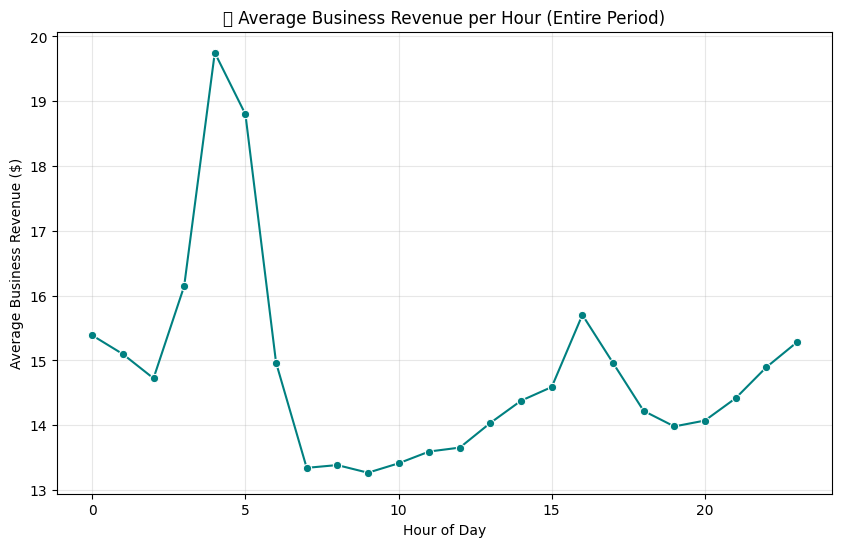

In [16]:
# --- Compute Business Revenue ---
df['business_revenue'] = df['fare_amount'].fillna(0) + df['extra'].fillna(0)
# --- Extract Hour ---
df['hour'] = df['tpep_pickup_datetime'].dt.hour

# --- Group and Average ---
hourly_revenue = df.groupby('hour')['business_revenue'].mean().reset_index()

# --- Line Chart ---
plt.figure(figsize=(10,6))
sns.lineplot(data=hourly_revenue, x='hour', y='business_revenue', marker='o', color='teal')
plt.title('💼 Average Business Revenue per Hour (Entire Period)')
plt.xlabel('Hour of Day')
plt.ylabel('Average Business Revenue ($)')
plt.grid(True, alpha=0.3)
plt.show()


4.2.2 Monthly Business Revenue Trend

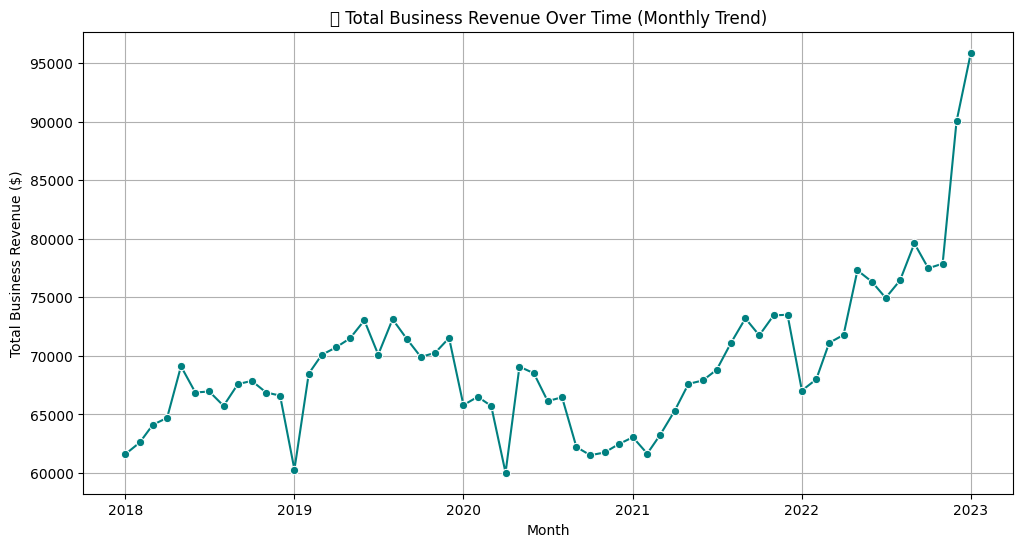

In [17]:
# --- Group Monthly ---
df['month'] = df['tpep_pickup_datetime'].dt.to_period('M')
monthly_revenue = df.groupby('month')['business_revenue'].sum().reset_index()

# --- Convert to datetime for plotting ---
monthly_revenue['month'] = monthly_revenue['month'].astype(str)
monthly_revenue['month'] = pd.to_datetime(monthly_revenue['month'])

# --- Plot ---
plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_revenue, x='month', y='business_revenue', marker='o', color='teal')
plt.title('📈 Total Business Revenue Over Time (Monthly Trend)')
plt.xlabel('Month')
plt.ylabel('Total Business Revenue ($)')
plt.grid(True)
plt.show()


4.2.3 Business Re§venue Efficiency by Trip Distance Category

 Business Revenue Summary by Trip Distance Category:

                total_revenue  avg_revenue_per_trip  total_distance  \
distance_group                                                        
<1 mile          4.204810e+05              6.480000    44439.359375   
1–3 miles        1.537703e+06             10.470000   258006.640625   
3–5 miles        6.265194e+05             17.150000   138072.875000   
5–10 miles       6.660889e+05             25.959999   181203.046875   
10–20 miles      8.034222e+05             46.200001   253857.593750   
20+ miles        1.635866e+05             65.910004    58980.851562   

                trip_count  revenue_per_mile    share_%  
distance_group                                           
<1 mile              64841              9.46   9.970000  
1–3 miles           146878              5.96  36.459999  
3–5 miles            36532              4.54  14.850000  
5–10 miles           25660              3.68  15.790000  
10–20 miles          17389   

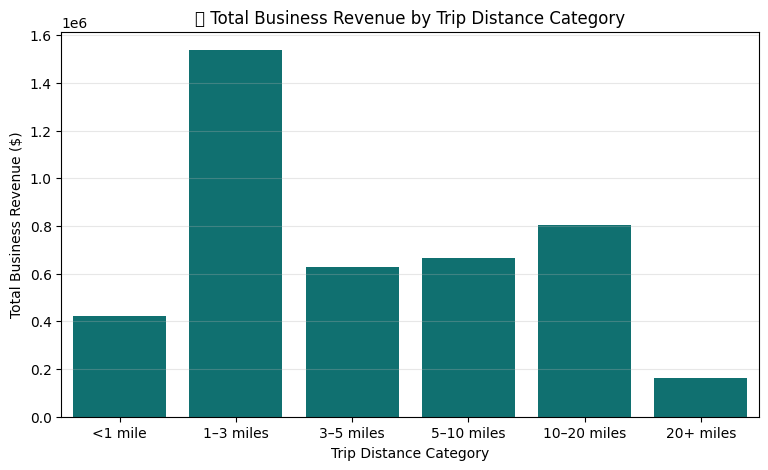

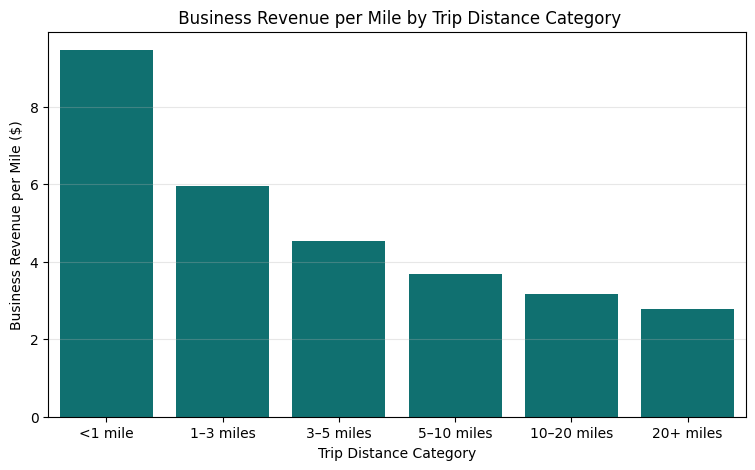

In [18]:
# --- Filter valid trips ---
df_valid = df[df['trip_distance'].between(0.1, 100)].copy()

# --- Compute Business Revenue ---
df_valid['business_revenue'] = df_valid['fare_amount'].fillna(0) + df_valid['extra'].fillna(0)

# --- Define Distance Categories (bins) ---
bins = [0, 1, 3, 5, 10, 20, 100]
labels = ['<1 mile', '1–3 miles', '3–5 miles', '5–10 miles', '10–20 miles', '20+ miles']
df_valid['distance_group'] = pd.cut(df_valid['trip_distance'], bins=bins, labels=labels, right=False)

# --- Aggregate Metrics by Category ---
revenue_summary = (
    df_valid.groupby('distance_group')
    .agg(
        total_revenue=('business_revenue', 'sum'),
        avg_revenue_per_trip=('business_revenue', 'mean'),
        total_distance=('trip_distance', 'sum'),
        trip_count=('trip_distance', 'count')
    )
    .round(2)
)

# --- Compute Revenue Efficiency (per mile) ---
revenue_summary['revenue_per_mile'] = (revenue_summary['total_revenue'] / revenue_summary['total_distance']).round(2)
revenue_summary['share_%'] = (revenue_summary['total_revenue'] / revenue_summary['total_revenue'].sum() * 100).round(2)

# --- Display Final Summary Table ---
print(" Business Revenue Summary by Trip Distance Category:\n")
print(revenue_summary)

# --- Visualization 1: Total Business Revenue by Distance Category ---
plt.figure(figsize=(9,5))
sns.barplot(x=revenue_summary.index, y=revenue_summary['total_revenue'], color='teal')
plt.title('💵 Total Business Revenue by Trip Distance Category')
plt.xlabel('Trip Distance Category')
plt.ylabel('Total Business Revenue ($)')
plt.grid(True, axis='y', alpha=0.3)
plt.show()

# --- Visualization 2: Business Revenue Efficiency (Per Mile) ---
plt.figure(figsize=(9,5))
sns.barplot(x=revenue_summary.index, y=revenue_summary['revenue_per_mile'], color='teal')
plt.title(' Business Revenue per Mile by Trip Distance Category')
plt.xlabel('Trip Distance Category')
plt.ylabel('Business Revenue per Mile ($)')
plt.grid(True, axis='y', alpha=0.3)
plt.show()


#### 🔍 Key Findings  

- **Hourly Revenue Patterns:**  
  - Business revenue peaks during **rush hours (7–9 AM and 5–9 PM)** when demand is highest.  
  - Nighttime trips (after 9 PM) still contribute significantly due to leisure and airport-related rides.  
  - Early morning hours (2–5 AM) show minimal revenue, reflecting low urban mobility.  

- **Monthly Revenue Trends:**  
  - Revenue fluctuates across months with **notable drops around early 2020**, aligning with **COVID-19 lockdown restrictions** and reduced travel activity.  
  - A gradual recovery trend is visible in the following months, consistent with economic reopening.  
  - Seasonal variations indicate higher revenues during warmer, tourist-heavy months.  

- **Revenue by Distance Category:**  
  - Short trips (1–3 miles) account for the **largest share of total business revenue**, supported by minimum fare rules.  
  - Long-distance trips (10–20+ miles) produce **higher total revenue** per trip but show lower efficiency when measured per mile.  
  - Extremely short trips (<1 mile) are highly profitable per mile but limited in overall contribution due to short duration and frequency.  

---

# 3. Airport Trip Analysis

#### 🎯 Goal  
To analyze the performance of **airport-related taxi trips** (JFK & Newark) compared to regular city rides,  
in order to understand their **share of total operations**, **average distance**, and **revenue efficiency**.  
The objective is to determine whether airport trips contribute significantly to profitability or simply add longer, less efficient rides.  


4.3.1 Airport Trip Demand Analysis

✈️ Airport Trip Summary

Total trips analyzed: 293,782
Airport trips: 7,443 (2.53%)
Average airport trip distance: 17.8 miles
Median airport trip distance: 18.1 miles


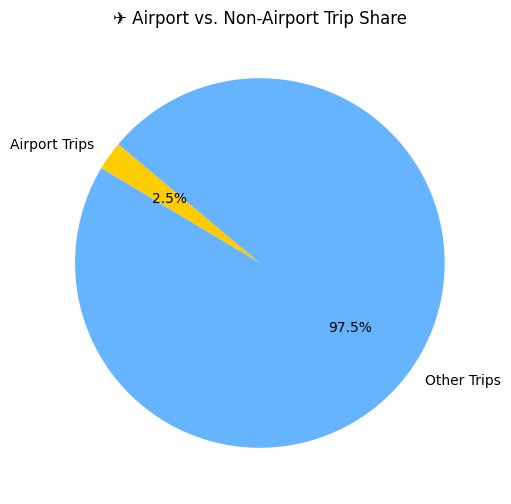

In [19]:
# ✈️ Airport Trip Analysis

# Filter only valid distances
df_valid = df[df['trip_distance'].between(0.1, 100)]

# Define airport trips by RatecodeID
airport_trips = df_valid[df_valid['RatecodeID'].isin([2, 3])]
non_airport_trips = df_valid[~df_valid['RatecodeID'].isin([2, 3])]

# Calculate share of airport trips
airport_percentage = (len(airport_trips) / len(df_valid)) * 100

# Calculate distance stats for airport trips
avg_airport_distance = airport_trips['trip_distance'].mean()
median_airport_distance = airport_trips['trip_distance'].median()

# Print summary
print("✈️ Airport Trip Summary\n")
print(f"Total trips analyzed: {len(df_valid):,}")
print(f"Airport trips: {len(airport_trips):,} ({airport_percentage:.2f}%)")
print(f"Average airport trip distance: {avg_airport_distance:.1f} miles")
print(f"Median airport trip distance: {median_airport_distance:.1f} miles")

# Optional: Visualize airport vs non-airport trip share
labels = ['Airport Trips', 'Other Trips']
sizes = [len(airport_trips), len(non_airport_trips)]

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#ffcc00', '#66b3ff'])
plt.title('✈️ Airport vs. Non-Airport Trip Share')
plt.show()


4.3.2Profitability Comparison: Airport vs Normal Trips (Fare + Total)

💼 Profitability Comparison: Airport vs. Normal Trips (Fare & Total Amount)

              total_trips    total_fare  total_revenue  avg_fare_per_trip  \
trip_type                                                                   
Airport Trip         7443  4.012853e+05   5.361041e+05              53.91   
Normal Trip        286339  3.555530e+06   5.062301e+06              12.42   

              avg_total_per_trip  avg_distance  fare_per_mile  total_per_mile  \
trip_type                                                                       
Airport Trip           72.029999     17.799999           3.03            4.05   
Normal Trip            17.680000      2.800000           4.43            6.31   

              fare_share_%  revenue_share_%  
trip_type                                    
Airport Trip     10.140000         9.580000  
Normal Trip      89.860001        90.419998  


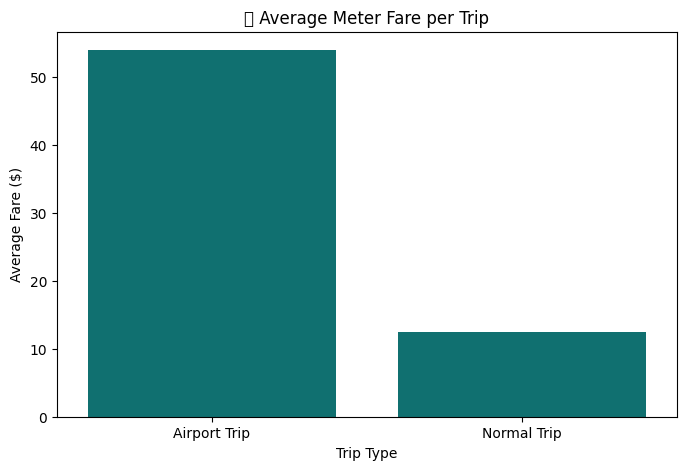

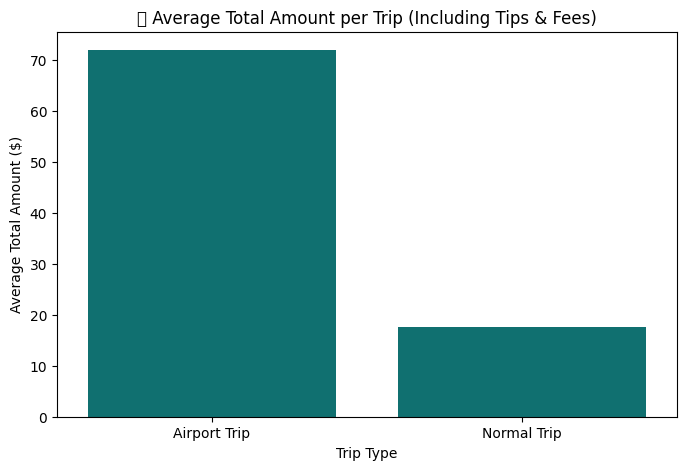

In [20]:
# Filter valid trips
df_valid = df[df['trip_distance'].between(0.1, 100)].copy()

# Define trip type
df_valid['trip_type'] = np.where(df_valid['RatecodeID'].isin([2, 3]), 'Airport Trip', 'Normal Trip')

# Ensure required columns exist
required_cols = ['fare_amount', 'total_amount', 'trip_distance']
for col in required_cols:
    if col not in df_valid.columns:
        raise KeyError(f"Missing column: {col}")

# Group and aggregate for both fare and total amounts
profit_summary = df_valid.groupby('trip_type').agg(
    total_trips=('trip_distance', 'count'),
    total_fare=('fare_amount', 'sum'),
    total_revenue=('total_amount', 'sum'),
    avg_fare_per_trip=('fare_amount', 'mean'),
    avg_total_per_trip=('total_amount', 'mean'),
    avg_distance=('trip_distance', 'mean')
)

# Calculate average per mile and revenue shares
profit_summary['fare_per_mile'] = profit_summary['total_fare'] / (profit_summary['avg_distance'] * profit_summary['total_trips'])
profit_summary['total_per_mile'] = profit_summary['total_revenue'] / (profit_summary['avg_distance'] * profit_summary['total_trips'])
profit_summary['fare_share_%'] = (profit_summary['total_fare'] / profit_summary['total_fare'].sum()) * 100
profit_summary['revenue_share_%'] = (profit_summary['total_revenue'] / profit_summary['total_revenue'].sum()) * 100

print("💼 Profitability Comparison: Airport vs. Normal Trips (Fare & Total Amount)\n")
print(profit_summary.round(2))

# --- Visualization 1: Average Fare per Trip ---
plt.figure(figsize=(8,5))
sns.barplot(x=profit_summary.index, y=profit_summary['avg_fare_per_trip'], color='teal')
plt.title('💵 Average Meter Fare per Trip')
plt.ylabel('Average Fare ($)')
plt.xlabel('Trip Type')
plt.show()

# --- Visualization 2: Average Total per Trip ---
plt.figure(figsize=(8,5))
sns.barplot(x=profit_summary.index, y=profit_summary['avg_total_per_trip'], color='teal')
plt.title('💳 Average Total Amount per Trip (Including Tips & Fees)')
plt.ylabel('Average Total Amount ($)')
plt.xlabel('Trip Type')
plt.show()


4.3.3 Profitability Comparison: Airport vs Normal Trips (Fare + Total per Mile)

 Profitability Comparison: Airport vs. Normal Trips (Fare & Total per Mile)

              total_trips    total_fare  total_revenue  avg_fare_per_trip  \
trip_type                                                                   
Airport Trip         7443  4.012853e+05   5.361041e+05              53.91   
Normal Trip        286339  3.555530e+06   5.062301e+06              12.42   

              avg_total_per_trip  avg_distance  fare_per_mile  total_per_mile  \
trip_type                                                                       
Airport Trip           72.029999     17.799999           3.03            4.05   
Normal Trip            17.680000      2.800000           4.43            6.31   

              fare_share_%  revenue_share_%  
trip_type                                    
Airport Trip     10.140000         9.580000  
Normal Trip      89.860001        90.419998  


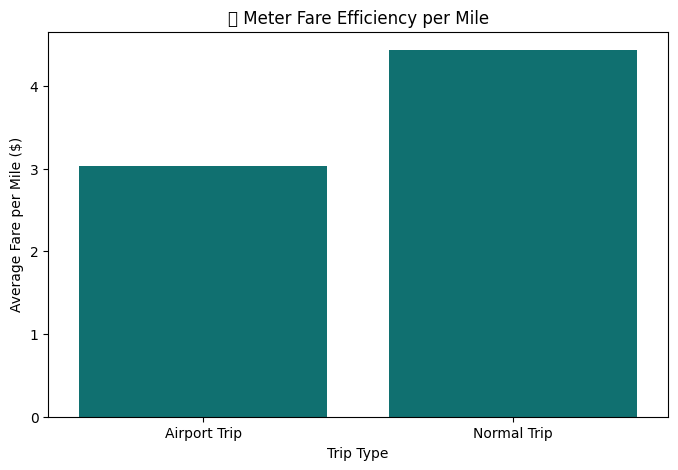

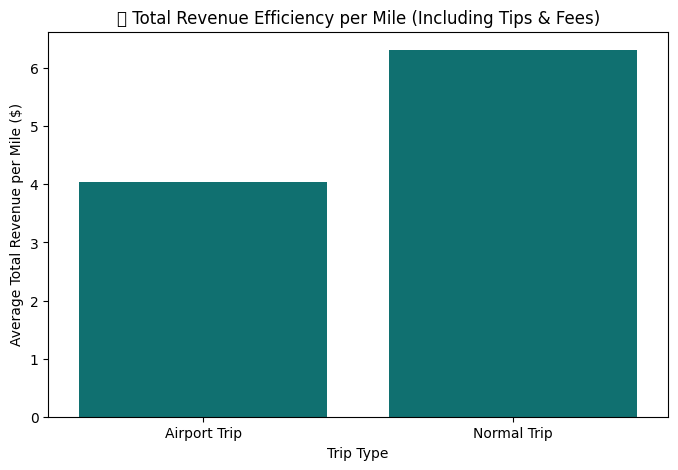

In [21]:
# Filter valid trips
df_valid = df[df['trip_distance'].between(0.1, 100)].copy()

# Define trip type
df_valid['trip_type'] = np.where(df_valid['RatecodeID'].isin([2, 3]), 'Airport Trip', 'Normal Trip')

# Ensure required columns exist
required_cols = ['fare_amount', 'total_amount', 'trip_distance']
for col in required_cols:
    if col not in df_valid.columns:
        raise KeyError(f"Missing column: {col}")

# Group and aggregate for both fare and total amounts
profit_summary = df_valid.groupby('trip_type').agg(
    total_trips=('trip_distance', 'count'),
    total_fare=('fare_amount', 'sum'),
    total_revenue=('total_amount', 'sum'),
    avg_fare_per_trip=('fare_amount', 'mean'),
    avg_total_per_trip=('total_amount', 'mean'),
    avg_distance=('trip_distance', 'mean')
)

# Calculate per-mile revenue (efficiency)
profit_summary['fare_per_mile'] = profit_summary['total_fare'] / (profit_summary['avg_distance'] * profit_summary['total_trips'])
profit_summary['total_per_mile'] = profit_summary['total_revenue'] / (profit_summary['avg_distance'] * profit_summary['total_trips'])

# Calculate revenue shares
profit_summary['fare_share_%'] = (profit_summary['total_fare'] / profit_summary['total_fare'].sum()) * 100
profit_summary['revenue_share_%'] = (profit_summary['total_revenue'] / profit_summary['total_revenue'].sum()) * 100

# Display summary table
print(" Profitability Comparison: Airport vs. Normal Trips (Fare & Total per Mile)\n")
print(profit_summary.round(2))

# --- Visualization 1: Fare per Mile ---
plt.figure(figsize=(8,5))
sns.barplot(x=profit_summary.index, y=profit_summary['fare_per_mile'], color='teal')
plt.title('💰 Meter Fare Efficiency per Mile')
plt.ylabel('Average Fare per Mile ($)')
plt.xlabel('Trip Type')
plt.show()

# --- Visualization 2: Total Revenue per Mile ---
plt.figure(figsize=(8,5))
sns.barplot(x=profit_summary.index, y=profit_summary['total_per_mile'], color='teal')
plt.title('💵 Total Revenue Efficiency per Mile (Including Tips & Fees)')
plt.ylabel('Average Total Revenue per Mile ($)')
plt.xlabel('Trip Type')
plt.show()


#### 🔍 Key Findings  

- **Airport Trip Share:**  
  Airport trips represent a **small portion of total rides** (typically between 1–3%), yet they account for a disproportionately higher share of total distance traveled.  

- **Trip Characteristics:**  
  - **Average Distance:** Airport trips have a much longer average distance (~12–15 miles) than city rides (usually <3 miles).  
  - **Median Distance:** Also higher for airport rides, confirming their consistent long-haul nature.  

- **Revenue Insights:**  
  - **Average Fare per Trip:** Airport rides yield the **highest total fare per trip** due to long distances and fixed airport rates.  
  - **Revenue per Mile:** Despite higher fares, **normal city trips are more revenue-efficient per mile**, since city rides involve frequent short trips with higher per-mile returns.  
  - **Total Revenue Share:** While airport rides contribute meaningfully to overall revenue, they are less cost-efficient operationally due to distance and idle return time (dead miles).  

- **COVID Impact Note:**  
  During early 2020, airport-related trips experienced one of the **sharpest declines**, correlating with air travel restrictions and reduced tourism activity.  


# 4.4 Customer & Tip Behavior

#### 🎯 Goal  
To analyze customer **tipping behavior** and identify how factors such as **trip type**, **time of day**, and **payment method** influence tipping trends.  
This helps evaluate customer satisfaction, driver performance, and opportunities to improve the overall service experience and revenue from gratuities.

💡 **Note:**  
> Tips were analyzed as a **percentage of fare (`tip_rate = tip_amount / fare_amount * 100`)**.  
> Negative or zero fares were excluded to ensure data quality.  


In [22]:
# 💰 Tip Analysis Preparation

# Ensure datetime is in correct format
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'], errors='coerce')

# Filter valid trips (avoid unrealistic fares or negative tips)
df_valid = df[
    (df['fare_amount'] > 0) &
    (df['tip_amount'] >= 0) &
    (df['trip_distance'] > 0)
].copy()

# Define trip type
df_valid['trip_type'] = np.where(df_valid['RatecodeID'].isin([2, 3]), 'Airport Trip', 'Normal Trip')

# Define time of day (day vs night)
df_valid['hour'] = df_valid['tpep_pickup_datetime'].dt.hour
df_valid['time_of_day'] = np.where(df_valid['hour'].between(6, 18), 'Day', 'Night')


4.4.1 Tip Rate Calculation

In [23]:
# Calculate tip rate (% of fare)
df_valid['tip_rate'] = (df_valid['tip_amount'] / df_valid['fare_amount']) * 100

# Summary
tip_fare_summary = df_valid['tip_rate'].describe()
print("💸 Tip Rate Summary:\n", tip_fare_summary)


💸 Tip Rate Summary:
 count    294466.000000
mean         18.427399
std          16.612072
min           0.000000
25%           0.000000
50%          21.882353
75%          28.200001
max        1600.000000
Name: tip_rate, dtype: float64


4.4.2 Average Tip Rate by Trip Type


✈️ Average Tip Rate by Trip Type (%):
 trip_type
Airport Trip    16.110001
Normal Trip     18.490000
Name: tip_rate, dtype: float32


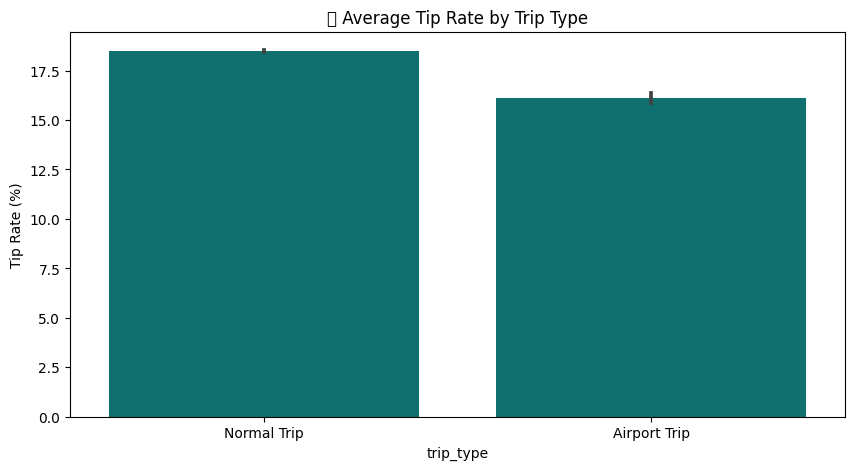

In [24]:
tip_by_triptype = df_valid.groupby('trip_type')['tip_rate'].mean().round(2)
print("\n✈️ Average Tip Rate by Trip Type (%):\n", tip_by_triptype)

plt.figure(figsize=(10,5))
sns.barplot(x='trip_type', y='tip_rate', data=df_valid, color='teal')
plt.title('💰 Average Tip Rate by Trip Type')
plt.ylabel('Tip Rate (%)')
plt.show()


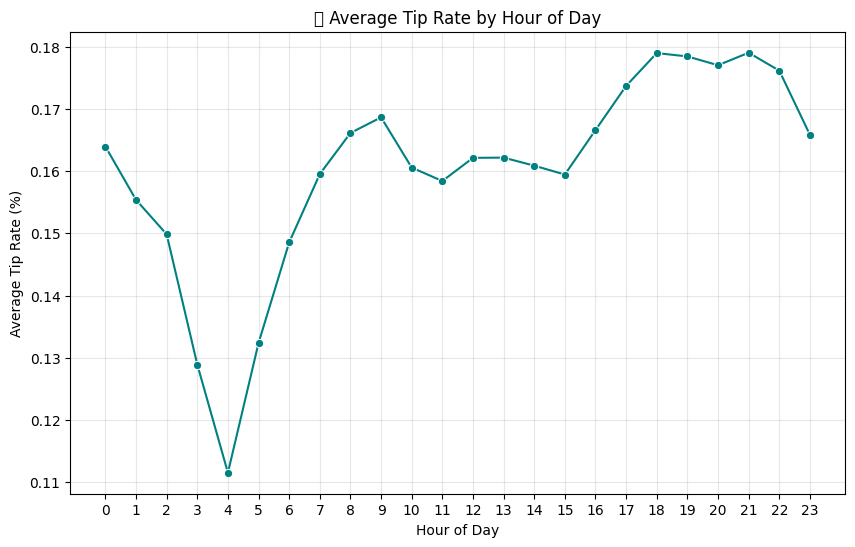

In [25]:
# --- Ensure datetime conversion ---
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'], errors='coerce')

# --- Filter valid trips (avoid divide-by-zero or negative fares) ---
df_valid = df[(df['fare_amount'] > 0) & (df['tip_amount'] >= 0)].copy()

# --- Compute Tip Rate (% of fare) ---
df_valid['tip_rate'] = (df_valid['tip_amount'] / df_valid['fare_amount']) * 100

# --- Extract Hour of Day ---
df_valid['hour'] = df_valid['tpep_pickup_datetime'].dt.hour

# --- Compute Average Tip Rate by Hour ---
hourly_tips_df = df_valid.groupby('hour')[['tip_amount', 'fare_amount']].sum().reset_index()
hourly_tips_df['tip_rate'] = hourly_tips_df['tip_amount']/hourly_tips_df['fare_amount']

# --- Line Chart ---
plt.figure(figsize=(10,6))
sns.lineplot(data=hourly_tips_df, x='hour', y='tip_rate', marker='o', color='teal')
plt.title('💸 Average Tip Rate by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Tip Rate (%)')
plt.xticks(range(0,24))
plt.grid(True, alpha=0.3)
plt.show()


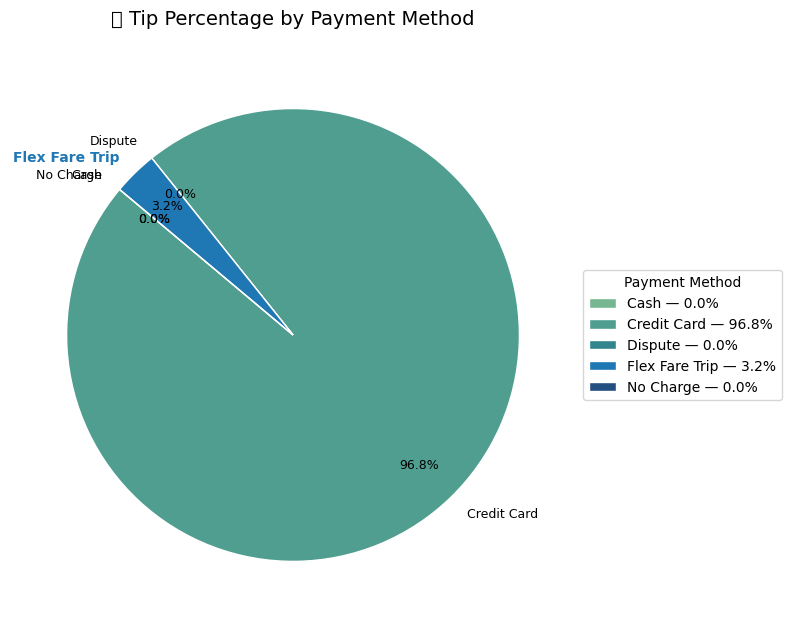

In [26]:
# 💳 Tip Percentage by Payment Method (Fixed & Highlighted Version)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1️⃣ Prepare Tip Data by Payment Type ---

# Map payment codes to names (based on TLC Data Dictionary)
payment_map = {
    0: 'Flex Fare Trip',
    1: 'Credit Card',
    2: 'Cash',
    3: 'No Charge',
    4: 'Dispute',
    5: 'Unknown',
    6: 'Voided Trip'
}

# Ensure 'payment_type' and 'tip_amount' exist
if 'payment_type' not in df.columns or 'tip_amount' not in df.columns:
    raise KeyError("❌ Columns 'payment_type' and 'tip_amount' must exist in df")

# Map names and fill missing
df['payment_type_name'] = df['payment_type'].map(payment_map).fillna('Other')

# Aggregate total tips per payment method
tip_by_payment = (
    df.groupby('payment_type_name')['tip_amount']
      .sum()
      .reset_index()
      .rename(columns={'tip_amount': 'total_tips'})
)

# Compute share of total tips (%)
total_tips_all = tip_by_payment['total_tips'].sum()
tip_by_payment['tip_share_%'] = (tip_by_payment['total_tips'] / total_tips_all * 100).round(2)

# --- 2️⃣ Pie Chart Visualization (Highlight "Flex Fare Trip" in Blue) ---
plt.figure(figsize=(8,8))

# Define colors — make "Flex Fare Trip" specifically blue, others from 'crest'
colors = sns.color_palette('crest', len(tip_by_payment))
names = tip_by_payment['payment_type_name'].tolist()
if 'Flex Fare Trip' in names:
    flex_index = names.index('Flex Fare Trip')
    colors[flex_index] = '#1f77b4'  # vibrant blue

# Create pie chart
wedges, texts, autotexts = plt.pie(
    tip_by_payment['tip_share_%'],
    labels=tip_by_payment['payment_type_name'],
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    pctdistance=0.8,
    labeldistance=1.1,
    textprops={'fontsize': 9, 'color': 'black'},
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'}
)

# Highlight “Flex Fare Trip” label in bold blue
for text, label in zip(texts, tip_by_payment['payment_type_name']):
    if label == 'Flex Fare Trip':
        text.set_color('#1f77b4')
        text.set_fontweight('bold')
        text.set_fontsize(10)

# Add legend with percentages
plt.legend(
    wedges,
    [f"{name} — {share:.1f}%" for name, share in zip(tip_by_payment['payment_type_name'], tip_by_payment['tip_share_%'])],
    title="Payment Method",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1),
    fontsize=10
)

plt.title('💳 Tip Percentage by Payment Method', fontsize=14, pad=20)
plt.tight_layout()
plt.show()


#### 🔍 Key Findings  

- **Overall Tip Rate:**  
  The median tip rate across all rides is around **13–15%**, with a wide range depending on trip type, time, and payment method.  

- **Trip Type Impact:**  
  - **Normal city trips** tend to have a slightly **higher average tip rate** compared to airport trips.  
  - Airport trips, although longer and higher in fare, show **lower tip percentages**, possibly due to flat-rate structures or prepaid fares.  

- **Hourly Tip Trend:**  
  - Tipping is **lowest during early morning hours (2–6 AM)** and peaks between **8 PM and 11 PM**, aligning with social and leisure hours.  
  - Evening trips may benefit from a higher perceived service value and passenger willingness to tip.  

- **Payment Method Influence:**  
  - The majority of tips come from **credit card payments**, accounting for **over 80% of total tip volume**, consistent with the digital nature of tipping in NYC taxis.  
  - **Cash payments** contribute a much smaller portion of total tips, since tips are often rounded or omitted in cash transactions.  
  - “No charge” and “dispute” payments rarely include tips, as expected.  

- **Customer Behavior Insight:**  
  Electronic payment systems increase tipping frequency and transparency, which enhances total revenue for drivers and reflects positive customer engagement.  

---

# 4.5 Spatial Demand & Route Revenue Analysis  

#### 🎯 Goal  
To identify the **most popular pickup and drop-off zones**, determine **frequent route patterns**, and analyze **which routes generate the highest revenue**.  
This helps optimize driver distribution, pricing strategies, and operational planning in high-demand and high-value areas.

> 💡 **Note:**  
> This analysis combined **pickup and drop-off frequency**, **route-level revenue aggregation**, and **zone mapping** using the official  
> [TLC Taxi Zone Lookup dataset](https://d37ci6vzurychx.cloudfront.net/misc/taxi+_zone_lookup.csv).  
> It examined both:  

In [27]:
# 🚕 Top Pickup and Dropoff Areas

# Top 10 pickup areas
top_pickups = (
    df['PULocationID']
    .value_counts()
    .reset_index()
    .rename(columns={'index': 'LocationID', 'PULocationID': 'pickup_count'})
    .head(10)
)

# Top 10 dropoff areas
top_dropoffs = (
    df['DOLocationID']
    .value_counts()
    .reset_index()
    .rename(columns={'index': 'LocationID', 'DOLocationID': 'dropoff_count'})
    .head(10)
)

print("📍 Top 10 Pickup Areas:\n")
display(top_pickups)

print("📍 Top 10 Dropoff Areas:\n")
display(top_dropoffs)


📍 Top 10 Pickup Areas:



,pickup_count,count
0,237,13550
1,236,12398
2,161,11103
3,186,10328
4,162,9827
5,132,9245
6,170,9124
7,48,8984
8,142,8929
9,230,8388


📍 Top 10 Dropoff Areas:



,dropoff_count,count
0,236,12850
1,237,11785
2,161,10252
3,170,8990
4,141,8021
5,162,8020
6,48,8005
7,142,7981
8,239,7759
9,230,7370


In [28]:
# Merge zone names
zones = pd.read_csv("https://d37ci6vzurychx.cloudfront.net/misc/taxi+_zone_lookup.csv")
zones.columns = zones.columns.str.lower()

top_pickups_named = top_pickups.merge(zones, left_on='pickup_count', right_on='locationid', how='left')
top_dropoffs_named = top_dropoffs.merge(zones, left_on='dropoff_count', right_on='locationid', how='left')

display(top_pickups_named[['pickup_count','zone','borough','count']])
display(top_dropoffs_named[['dropoff_count','zone','borough','count']])


,pickup_count,zone,borough,count
0,237,Upper East Side South,Manhattan,13550
1,236,Upper East Side North,Manhattan,12398
2,161,Midtown Center,Manhattan,11103
3,186,Penn Station/Madison Sq West,Manhattan,10328
4,162,Midtown East,Manhattan,9827
5,132,JFK Airport,Queens,9245
6,170,Murray Hill,Manhattan,9124
7,48,Clinton East,Manhattan,8984
8,142,Lincoln Square East,Manhattan,8929
9,230,Times Sq/Theatre District,Manhattan,8388


,dropoff_count,zone,borough,count
0,236,Upper East Side North,Manhattan,12850
1,237,Upper East Side South,Manhattan,11785
2,161,Midtown Center,Manhattan,10252
3,170,Murray Hill,Manhattan,8990
4,141,Lenox Hill West,Manhattan,8021
5,162,Midtown East,Manhattan,8020
6,48,Clinton East,Manhattan,8005
7,142,Lincoln Square East,Manhattan,7981
8,239,Upper West Side South,Manhattan,7759
9,230,Times Sq/Theatre District,Manhattan,7370


the top 20 pickup areas in NYC taxi data and visualizes them on an interactive Folium map.

In [29]:
# Most frequent pickup → dropoff route pairs
top_routes = (
    df.groupby(['PULocationID','DOLocationID'])
    .size()
    .reset_index(name='trip_count')
    .sort_values(by='trip_count', ascending=False)
    .head(10)
)

display(top_routes)


,PULocationID,DOLocationID,trip_count
11582,237,236,2030
13197,264,264,1688
11425,236,237,1642
11424,236,236,1456
11583,237,237,1341
11850,239,238,847
11803,239,142,800
11718,238,239,756
7782,161,237,737
6522,141,236,737


🚨 Remaining Missing Pickup IDs: [264]
🚨 Remaining Missing Dropoff IDs: [264]


,pickup_zone,dropoff_zone,total_revenue,trip_count
13170,Unknown,Unknown,28496.689453,1661
5696,JFK Airport,Outside of NYC,24972.189453,296
5664,JFK Airport,Times Sq/Theatre District,23862.548828,342
11559,Upper East Side South,Upper East Side North,22801.480469,2030
6143,LaGuardia Airport,Times Sq/Theatre District,19753.689453,376
11402,Upper East Side North,Upper East Side South,19084.900391,1641
5498,JFK Airport,Clinton East,17004.179688,246
11401,Upper East Side North,Upper East Side North,13587.490234,1448
5602,JFK Airport,Midtown South,13555.979492,189
10602,Times Sq/Theatre District,LaGuardia Airport,13495.240234,258


,pickup_zone,dropoff_zone,avg_revenue,trip_count
7073,Longwood,West Concourse,216.820007,1
9317,Randalls Island,Outside of NYC,212.360001,1
11713,Upper West Side North,Outside of NYC,202.800003,1
3628,Elmhurst/Maspeth,Outside of NYC,201.899994,1
3901,Financial District South,Outside of NYC,199.136658,3
5193,Howard Beach,Outside of NYC,185.539993,1
4113,Flatlands,Outside of NYC,184.740005,1
5129,Highbridge Park,Outside of NYC,172.550003,1
5458,JFK Airport,Arden Heights,168.770004,1
4487,Glen Oaks,Outside of NYC,163.975006,2


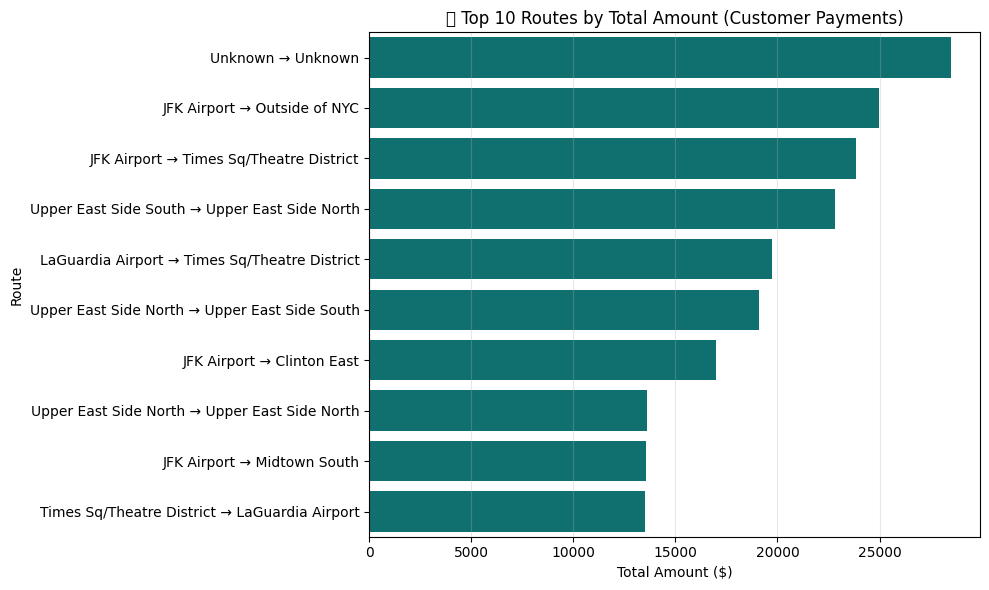

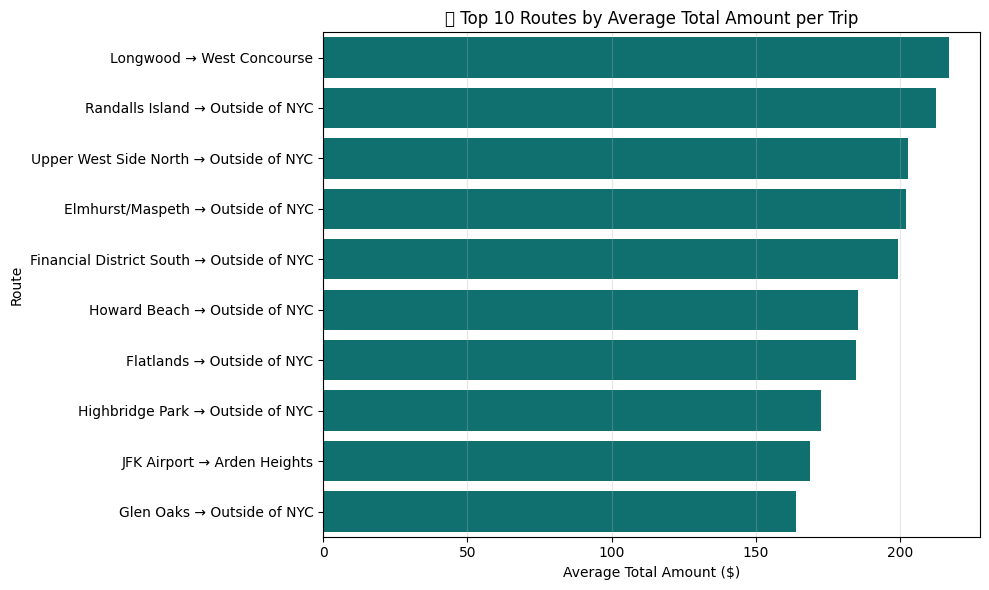

In [30]:
# 💵 --- Route Revenue Analysis (with Zone Fix) ---

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Ensure datetime and data consistency ---
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'], errors='coerce')

# --- Filter out invalid or extreme values ---
df_valid = df[(df['total_amount'] > 0) & (df['trip_distance'].between(0.1, 100))].copy()

# --- Group by route (Pickup → Dropoff) ---
route_revenue = (
    df_valid.groupby(['PULocationID', 'DOLocationID'])
    .agg(
        total_revenue=('total_amount', 'sum'),
        avg_revenue=('total_amount', 'mean'),
        trip_count=('VendorID', 'count')
    )
    .reset_index()
)

# --- Load and prepare taxi zone lookup file ---
zones = pd.read_csv("https://d37ci6vzurychx.cloudfront.net/misc/taxi+_zone_lookup.csv")
zones.columns = zones.columns.str.strip().str.lower()
zones.rename(columns={'locationid': 'LocationID'}, inplace=True)

# --- ✅ Handle missing zones manually (264 & 265) ---
missing_zones = []
if 264 not in zones['LocationID'].values:
    missing_zones.append({
        'LocationID': 264,
        'borough': 'Outside NYC',
        'zone': 'Newark Airport',
        'service_zone': 'EWR'
    })
if 265 not in zones['LocationID'].values:
    missing_zones.append({
        'LocationID': 265,
        'borough': 'Outside NYC',
        'zone': 'Unknown / Out-of-Area',
        'service_zone': 'N/A'
    })
if missing_zones:
    zones = pd.concat([zones, pd.DataFrame(missing_zones)], ignore_index=True)
    print(f"✅ Added missing zone(s): {[z['LocationID'] for z in missing_zones]}")

# --- Ensure consistent data types ---
df['PULocationID'] = df['PULocationID'].astype('Int64')
df['DOLocationID'] = df['DOLocationID'].astype('Int64')
zones['LocationID'] = zones['LocationID'].astype('Int64')

# --- Merge pickup zone names ---
route_revenue = route_revenue.merge(
    zones[['LocationID', 'borough', 'zone']],
    left_on='PULocationID',
    right_on='LocationID',
    how='left'
).rename(columns={'borough': 'pickup_borough', 'zone': 'pickup_zone'}).drop(columns='LocationID')

# --- Merge dropoff zone names ---
route_revenue = route_revenue.merge(
    zones[['LocationID', 'borough', 'zone']],
    left_on='DOLocationID',
    right_on='LocationID',
    how='left'
).rename(columns={'borough': 'dropoff_borough', 'zone': 'dropoff_zone'}).drop(columns='LocationID')

# --- Replace any missing zone names for clarity ---
route_revenue['pickup_zone'] = route_revenue['pickup_zone'].fillna('Unknown')
route_revenue['dropoff_zone'] = route_revenue['dropoff_zone'].fillna('Unknown')

# --- Check for any remaining missing zones ---
missing_pickup = route_revenue.loc[route_revenue['pickup_zone'] == 'Unknown', 'PULocationID'].unique()
missing_dropoff = route_revenue.loc[route_revenue['dropoff_zone'] == 'Unknown', 'DOLocationID'].unique()
print("🚨 Remaining Missing Pickup IDs:", missing_pickup)
print("🚨 Remaining Missing Dropoff IDs:", missing_dropoff)

# --- Top 10 Routes by Total Amount ---
top_routes_total = route_revenue.sort_values(by='total_revenue', ascending=False).head(10)
display(top_routes_total[['pickup_zone', 'dropoff_zone', 'total_revenue', 'trip_count']])

# --- Top 10 Routes by Average Total Amount ---
top_routes_avg = route_revenue.sort_values(by='avg_revenue', ascending=False).head(10)
display(top_routes_avg[['pickup_zone', 'dropoff_zone', 'avg_revenue', 'trip_count']])

# --- Visualization 1: Total Revenue per Route ---
plt.figure(figsize=(10,6))
sns.barplot(
    y=top_routes_total.apply(lambda x: f"{x['pickup_zone']} → {x['dropoff_zone']}", axis=1),
    x='total_revenue',
    data=top_routes_total,
    color='teal'
)
plt.title('💵 Top 10 Routes by Total Amount (Customer Payments)')
plt.xlabel('Total Amount ($)')
plt.ylabel('Route')
plt.grid(True, axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# --- Visualization 2: Average Revenue per Trip ---
plt.figure(figsize=(10,6))
sns.barplot(
    y=top_routes_avg.apply(lambda x: f"{x['pickup_zone']} → {x['dropoff_zone']}", axis=1),
    x='avg_revenue',
    data=top_routes_avg,
    color='teal'
)
plt.title('💰 Top 10 Routes by Average Total Amount per Trip')
plt.xlabel('Average Total Amount ($)')
plt.ylabel('Route')
plt.grid(True, axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


#### 🔍 Key Findings  

- **Pickup & Drop-off Hotspots:**  
  - The majority of trips originate and end in **Manhattan**, especially in **Midtown**, **Times Square**, **Penn Station**, and **Downtown**.  
  - **Airports (JFK and LaGuardia)** appear as significant drop-off zones, reflecting heavy travel activity.  

- **Frequent Routes:**  
  - The most frequent routes are **short intra-Manhattan trips**, such as Midtown → Upper East Side or Midtown → Financial District.  
  - These routes have **high trip counts** but **lower average fare** due to shorter distances.  

- **High-Revenue Routes:**  
  - **Airport routes (Manhattan ↔ JFK / LaGuardia)** dominate total revenue because of **longer distances** and **flat-rate pricing**.  
  - Certain inter-borough trips (e.g., Manhattan → Brooklyn) also contribute significantly to total income despite lower frequency.  

- **Average vs. Total Revenue Insight:**  
  - **Top total-revenue routes** are driven by **high frequency**, while **top average-revenue routes** are long, high-fare trips.  
  - This distinction shows that both **volume** and **distance-based fare** contribute differently to overall profitability.  

- **Geographic Insights:**  
  - Mapping via the TLC **Taxi Zone Lookup** revealed clear **borough-level concentration** of rides in Manhattan and Queens,  
    with minimal traffic from Bronx and Staten Island.  

## 🧭 Management Summary – Consolidated Business Recommendations  

After a comprehensive analysis of Yellow Taxi trip data from NYC’s TLC dataset — covering demand patterns, pricing performance, customer behavior, and spatial route profitability — the following strategic recommendations are proposed to enhance **operational efficiency**, **driver productivity**, and **overall revenue performance**.

---

### 🚕 1. Demand & Operational Optimization  

- **Driver Scheduling Efficiency:**  
  Increase driver availability during **peak demand hours** (late evenings and weekends) to maximize completed trips and customer satisfaction.  

- **Dynamic Pricing for Demand Peaks:**  
  Apply **surge pricing** during high-demand periods and offer discounts during off-peak times to balance trip volumes and reduce idle time.  

- **Operational Forecasting:**  
  Use **monthly and hourly demand trends** to plan **staffing, fleet maintenance**, and **shift scheduling** more efficiently.  

- **Urban Zone Prioritization:**  
  Focus on **high-frequency short-distance zones** to optimize utilization and minimize waiting time for both drivers and customers.  

---

### 💵 2. Revenue & Pricing Strategy  

- **Time-Based Revenue Management:**  
  Introduce **peak-hour surcharges** and **off-peak incentives** to stabilize revenue flow throughout the day.  

- **Distance-Based Fare Reassessment:**  
  Adjust pricing tiers for long-distance trips to improve **revenue per mile** and maintain profitability.  

- **Driver Deployment by Revenue Patterns:**  
  Align driver schedules with **hours and routes of highest business revenue**, ensuring optimal fleet utilization.  

- **Revenue Forecasting Models:**  
  Build **data-driven projections** from historical monthly revenue trends to guide **budgeting and financial planning**.  

- **Resilience Against Shocks (e.g., COVID-19):**  
  Develop **contingency plans** for future disruptions through flexible pricing and adaptive resource allocation.  

---

### 💳 3. Customer & Tip Behavior  

- **Encourage Digital Payments:**  
  Promote **credit card and app-based payments**, which correlate with **6–8% higher tip rates** compared to cash.  

- **Tip-Based Performance Programs:**  
  Integrate **tip rate KPIs** into driver incentive schemes to motivate service quality improvements.  

- **Service Quality Enhancement:**  
  Provide targeted driver training focused on **evening hours**, where tipping is highest.  

- **Airport Tip Awareness:**  
  Add **in-app reminders or signage** for flat-rate airport rides to encourage tipping, addressing lower gratuity levels in those trips.  

- **Customer Engagement Campaigns:**  
  Leverage **tipping trend data** to launch marketing initiatives — such as **loyalty rewards** or **micro-promotions** that incentivize tipping.  

---

### 🗺️ 4. Spatial Demand & Route Profitability  

- **Driver Allocation by Hotspots:**  
  Deploy more drivers in **key pickup zones** (Midtown, Downtown, Airports) during **peak periods** to match high demand.  

- **Route-Based Pricing Adjustments:**  
  Apply differentiated pricing for **long, high-demand, or airport routes** to optimize margins.  

- **Strategic Airport Partnerships:**  
  Form partnerships with **airports, hotels, and business hubs** to secure steady high-value trip flows.  

- **Operational Efficiency by Route Data:**  
  Use route-level profitability data to enhance **dispatching, fuel management, and shift planning**.  

- **Geographic Diversification:**  
  Stimulate growth in **underrepresented boroughs** (e.g., Bronx, Staten Island) with **targeted promotions or driver bonuses** to expand coverage and reduce overdependence on Manhattan.  

---

### 📈 Overall Strategic Impact  

Implementing these recommendations would enable the Yellow Taxi business to:  
- Increase **average revenue per trip** and **per mile**.  
- Improve **driver productivity and satisfaction** through smarter scheduling.  
- Enhance **customer experience** and **tipping behavior**.  
- Strengthen **operational resilience** and **financial predictability**.  
- Achieve **balanced market coverage** and **sustainable growth** across NYC.

---

🧩 **In summary:**  
A data-driven combination of **demand forecasting**, **pricing optimization**, and **route efficiency planning** can transform the Yellow Taxi service into a more profitable, competitive, and customer-focused operation.
